# Generating Predictive Models Tracked via MLflow

## Preprocessing
### Libraries

In [3]:
# Standard libraries
import warnings
import os
import tempfile

# Third-party libraries: General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import lightgbm as lgb
import shap
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Third-party libraries: scikit-learn and imblearn
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    make_scorer,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    confusion_matrix,
    fbeta_score,
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Local application/library specific imports
from business_cost_metric import business_cost_metric


warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

### Preprocessing Functions (Including Feature Engineering)
These functions were adapted from the Kaggle kernel "LightGBM with Simple Features" at https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script

In [4]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv("input/application_train.csv", nrows=num_rows)
    test_df = pd.read_csv("input/application_test.csv", nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df, test_df]).reset_index(drop=True)
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df["CODE_GENDER"] != "XNA"]

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ["CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY"]:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df["DAYS_EMPLOYED"].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df["DAYS_EMPLOYED_PERC"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    df["INCOME_CREDIT_PERC"] = df["AMT_INCOME_TOTAL"] / df["AMT_CREDIT"]
    df["INCOME_PER_PERSON"] = df["AMT_INCOME_TOTAL"] / df["CNT_FAM_MEMBERS"]
    df["ANNUITY_INCOME_PERC"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["PAYMENT_RATE"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
    del test_df
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv("input/bureau.csv", nrows=num_rows)
    bb = pd.read_csv("input/bureau_balance.csv", nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {"MONTHS_BALANCE": ["min", "max", "size"]}
    for col in bb_cat:
        bb_aggregations[col] = ["mean"]
    bb_agg = bb.groupby("SK_ID_BUREAU").agg(bb_aggregations)
    bb_agg.columns = pd.Index(
        [e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()]
    )
    bureau = bureau.join(bb_agg, how="left", on="SK_ID_BUREAU")
    bureau.drop(["SK_ID_BUREAU"], axis=1, inplace=True)
    del bb, bb_agg

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        "DAYS_CREDIT": ["min", "max", "mean", "var"],
        "DAYS_CREDIT_ENDDATE": ["min", "max", "mean"],
        "DAYS_CREDIT_UPDATE": ["mean"],
        "CREDIT_DAY_OVERDUE": ["max", "mean"],
        "AMT_CREDIT_MAX_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_DEBT": ["max", "mean", "sum"],
        "AMT_CREDIT_SUM_OVERDUE": ["mean"],
        "AMT_CREDIT_SUM_LIMIT": ["mean", "sum"],
        "AMT_ANNUITY": ["max", "mean"],
        "CNT_CREDIT_PROLONG": ["sum"],
        "MONTHS_BALANCE_MIN": ["min"],
        "MONTHS_BALANCE_MAX": ["max"],
        "MONTHS_BALANCE_SIZE": ["mean", "sum"],
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ["mean"]
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ["mean"]

    bureau_agg = bureau.groupby("SK_ID_CURR").agg(
        {**num_aggregations, **cat_aggregations}
    )
    bureau_agg.columns = pd.Index(
        ["BURO_" + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()]
    )
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau["CREDIT_ACTIVE_Active"] == 1]
    active_agg = active.groupby("SK_ID_CURR").agg(num_aggregations)
    active_agg.columns = pd.Index(
        ["ACTIVE_" + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(active_agg, how="left", on="SK_ID_CURR")
    del active, active_agg
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau["CREDIT_ACTIVE_Closed"] == 1]
    closed_agg = closed.groupby("SK_ID_CURR").agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ["CLOSED_" + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()]
    )
    bureau_agg = bureau_agg.join(closed_agg, how="left", on="SK_ID_CURR")
    del closed, closed_agg, bureau
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv("input/previous_application.csv", nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev["DAYS_FIRST_DRAWING"].replace(365243, np.nan, inplace=True)
    prev["DAYS_FIRST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE_1ST_VERSION"].replace(365243, np.nan, inplace=True)
    prev["DAYS_LAST_DUE"].replace(365243, np.nan, inplace=True)
    prev["DAYS_TERMINATION"].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev["APP_CREDIT_PERC"] = prev["AMT_APPLICATION"] / prev["AMT_CREDIT"]
    # Previous applications numeric features
    num_aggregations = {
        "AMT_ANNUITY": ["min", "max", "mean"],
        "AMT_APPLICATION": ["min", "max", "mean"],
        "AMT_CREDIT": ["min", "max", "mean"],
        "APP_CREDIT_PERC": ["min", "max", "mean", "var"],
        "AMT_DOWN_PAYMENT": ["min", "max", "mean"],
        "AMT_GOODS_PRICE": ["min", "max", "mean"],
        "HOUR_APPR_PROCESS_START": ["min", "max", "mean"],
        "RATE_DOWN_PAYMENT": ["min", "max", "mean"],
        "DAYS_DECISION": ["min", "max", "mean"],
        "CNT_PAYMENT": ["mean", "sum"],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ["mean"]

    prev_agg = prev.groupby("SK_ID_CURR").agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ["PREV_" + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()]
    )
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev["NAME_CONTRACT_STATUS_Approved"] == 1]
    approved_agg = approved.groupby("SK_ID_CURR").agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ["APPROVED_" + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(approved_agg, how="left", on="SK_ID_CURR")
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev["NAME_CONTRACT_STATUS_Refused"] == 1]
    refused_agg = refused.groupby("SK_ID_CURR").agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ["REFUSED_" + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()]
    )
    prev_agg = prev_agg.join(refused_agg, how="left", on="SK_ID_CURR")
    del refused, refused_agg, approved, approved_agg, prev
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv("input/POS_CASH_balance.csv", nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        "MONTHS_BALANCE": ["max", "mean", "size"],
        "SK_DPD": ["max", "mean"],
        "SK_DPD_DEF": ["max", "mean"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]

    pos_agg = pos.groupby("SK_ID_CURR").agg(aggregations)
    pos_agg.columns = pd.Index(
        ["POS_" + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()]
    )
    # Count pos cash accounts
    pos_agg["POS_COUNT"] = pos.groupby("SK_ID_CURR").size()
    del pos
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv("input/installments_payments.csv", nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins["PAYMENT_PERC"] = ins["AMT_PAYMENT"] / ins["AMT_INSTALMENT"]
    ins["PAYMENT_DIFF"] = ins["AMT_INSTALMENT"] - ins["AMT_PAYMENT"]
    # Days past due and days before due (no negative values)
    ins["DPD"] = ins["DAYS_ENTRY_PAYMENT"] - ins["DAYS_INSTALMENT"]
    ins["DBD"] = ins["DAYS_INSTALMENT"] - ins["DAYS_ENTRY_PAYMENT"]
    ins["DPD"] = ins["DPD"].apply(lambda x: x if x > 0 else 0)
    ins["DBD"] = ins["DBD"].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        "NUM_INSTALMENT_VERSION": ["nunique"],
        "DPD": ["max", "mean", "sum"],
        "DBD": ["max", "mean", "sum"],
        "PAYMENT_PERC": ["max", "mean", "sum", "var"],
        "PAYMENT_DIFF": ["max", "mean", "sum", "var"],
        "AMT_INSTALMENT": ["max", "mean", "sum"],
        "AMT_PAYMENT": ["min", "max", "mean", "sum"],
        "DAYS_ENTRY_PAYMENT": ["max", "mean", "sum"],
    }
    for cat in cat_cols:
        aggregations[cat] = ["mean"]
    ins_agg = ins.groupby("SK_ID_CURR").agg(aggregations)
    ins_agg.columns = pd.Index(
        ["INSTAL_" + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()]
    )
    # Count installments accounts
    ins_agg["INSTAL_COUNT"] = ins.groupby("SK_ID_CURR").size()
    del ins
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv("input/credit_card_balance.csv", nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(["SK_ID_PREV"], axis=1, inplace=True)
    cc_agg = cc.groupby("SK_ID_CURR").agg(["min", "max", "mean", "sum", "var"])
    cc_agg.columns = pd.Index(
        ["CC_" + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()]
    )
    # Count credit card lines
    cc_agg["CC_COUNT"] = cc.groupby("SK_ID_CURR").size()
    del cc
    return cc_agg

### Joining Tables and Saving Results

In [5]:
# Check whether the pretreated dataframes already exist; if they do, just read them into memory.
if not os.path.exists("input/train_df.ftr") or not os.path.exists("input/test_df.ftr"):
    # Pretreatment and feature engineering of combined application dfs
    df = application_train_test()
    # Pretreat and join bureau and balance tables to applications
    bureau = bureau_and_balance()
    df = df.join(bureau, how="left", on="SK_ID_CURR")

    # Save memory
    del bureau

    # Pretreat and join previous applications
    prev = previous_applications()
    df = df.join(prev, how="left", on="SK_ID_CURR")

    del prev

    # Pretreat and join pos
    pos = pos_cash()
    df = df.join(pos, how="left", on="SK_ID_CURR")

    del pos

    # Pretreat and join installments
    ins = installments_payments()
    df = df.join(ins, how="left", on="SK_ID_CURR")

    del ins

    # Pretreat and join credit card balance
    cc = credit_card_balance()
    df = df.join(cc, how="left", on="SK_ID_CURR")

    del cc

    # Seperate train and test dfs based on presence of TARGET
    train_df = df[df["TARGET"].notnull()].reset_index(drop=True)
    test_df = df[df["TARGET"].isnull()].reset_index(drop=True)

    del df

    # Save dfs to feather files
    train_df.to_feather("input/train_df.ftr")
    test_df.to_feather("input/test_df.ftr")

else:
    # Read pretreated dfs into memory if they already exist
    train_df = pd.read_feather("input/train_df.ftr")
    test_df = pd.read_feather("input/test_df.ftr")

# Show size of train and test dfs
print(f"train_df has {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
print(f"test_df has {test_df.shape[0]} rows and {test_df.shape[1]} columns.")

train_df has 307507 rows and 797 columns.
test_df has 48744 rows and 797 columns.


### Selecting the Top 50 Columns Most Correlated with 'TARGET'

**Purpose:**
- **Dimensionality Reduction**: The initial dataset had 797 columns. By selecting the 50 columns with the highest correlation to the 'TARGET', we've significantly reduced the dimensionality to 52 columns (including 'SK_ID_CURR' and 'TARGET'). This choice is partly influenced by computational constraints, ensuring that subsequent processing is efficient.

- **Arbitrary Selection**: The choice of exactly 50 columns, while influenced by computational considerations, is somewhat arbitrary. However, the aim was to strike a balance between computational efficiency and retaining meaningful data for subsequent steps.

- **Imputation**: By narrowing our focus to columns with significant correlations to the 'TARGET', we simplify and potentially improve the quality of subsequent imputation processes. Fewer columns might allow for more accurate imputation based on the existing relationships.
  
- **Oversampling**: When dealing with imbalanced datasets, the process of oversampling can introduce noise. By concentrating on the most relevant features, we aim to retain the most meaningful information and minimize the noise during oversampling.

In [6]:
# Calculate correlations for column 'TARGET' against all other columns
correlations = (
    train_df.drop(columns=["SK_ID_CURR"])
    .corr()["TARGET"]
    .drop("TARGET", errors="ignore")
)

# Sort correlations by absolute values but retain the original negative/positive values; reserve 50 columns with
# the most significant correlations
top_sorted_correlations = correlations.reindex(
    correlations.abs().nlargest(50).sort_values(ascending=False).index
)

# Display the resulting 50 columns with their correlation coefficients
with pd.option_context("display.max_rows", None):
    print(top_sorted_correlations)

# Filter the dataframe
train_df = train_df[["SK_ID_CURR", "TARGET"] + top_sorted_correlations.index.tolist()]

# Show size of train_df
print(f"\ntrain_df has {train_df.shape[0]} rows and {train_df.shape[1]} columns.")

EXT_SOURCE_3                              -0.178926
EXT_SOURCE_2                              -0.160471
EXT_SOURCE_1                              -0.155317
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN           0.107692
CC_CNT_DRAWINGS_CURRENT_MAX                0.101389
BURO_DAYS_CREDIT_MEAN                      0.089731
CC_AMT_BALANCE_MEAN                        0.087177
CC_AMT_TOTAL_RECEIVABLE_MEAN               0.086490
CC_AMT_RECIVABLE_MEAN                      0.086478
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN           0.086062
CC_CNT_DRAWINGS_CURRENT_MEAN               0.082520
BURO_MONTHS_BALANCE_SIZE_MEAN             -0.080193
BURO_CREDIT_ACTIVE_Closed_MEAN            -0.079369
DAYS_BIRTH                                 0.078242
PREV_NAME_CONTRACT_STATUS_Refused_MEAN     0.077681
BURO_CREDIT_ACTIVE_Active_MEAN             0.077356
BURO_DAYS_CREDIT_MIN                       0.075248
DAYS_EMPLOYED                              0.074957
PREV_CODE_REJECT_REASON_XAP_MEAN          -0.073938
CC_AMT_INST_

### Random Sampling of Train Data

To efficiently develop and test the predictive models, a smaller sample of the dataset is taken while ensuring that the class distribution in the `TARGET` variable remains relatively consistent. This strategy strikes a balance between computational efficiency and preserving the class distribution in the data. Given the significance of the class ratio in binary classification tasks, it's essential that this balance be maintained to ensure the sample is representative.

In [7]:
# Set the maximum tolerable difference in TARGET ratio between original and sampled sets of applicants
max_diff_threshold = 0.005  # 0.5 percent

# Get the initial ratio from the original dataframe
original_ratio = train_df["TARGET"].value_counts(normalize=True)

# Initialize sampled set
sampled_train_df = None

while True:
    # Taking random sample of applicants
    sampled_train_df = train_df.sample(n=10000)
    
    # Calculate the ratio in the sampled dataframe
    sampled_ratio = sampled_train_df["TARGET"].value_counts(normalize=True)
    
    # Check if the difference in ratios is within the desired threshold
    if abs(original_ratio.loc[1] - sampled_ratio.loc[1]) <= max_diff_threshold:
        break

# Display the ratios
print(f"Original dataframe TARGET ratio: {original_ratio}")
print(f"Sampled dataframe TARGET ratio: {sampled_ratio}")

Original dataframe TARGET ratio: TARGET
0.0    0.91927
1.0    0.08073
Name: proportion, dtype: float64
Sampled dataframe TARGET ratio: TARGET
0.0    0.9211
1.0    0.0789
Name: proportion, dtype: float64


### KNN Imputation for Missing Data

- Missing data is being addressed to ensure subsequently trained models, which cannot handle missing data, function properly.
- **KNN Imputation** has been chosen for this task:
  * It imputes missing values using the mean value from `k` nearest neighbors.
  * `k=5` has been used as a commonly recommended starting point, balancing computational cost and the ability to capture data patterns.
  * KNN captures patterns that simpler methods might miss.
- Given the reduced sample size, computational expense isn't a concern.

In [8]:
# Using KNN Imputer with 5 neighbors to impute missing values in the sampled_train_df,
# and then converting the resulting numpy array back into a DataFrame with the original column names.
sampled_train_df_imputed = pd.DataFrame(
    KNNImputer(n_neighbors=5).fit_transform(sampled_train_df),
    columns=sampled_train_df.columns,
)

## TODO
# Choose 20 most important features using kbest (sklearn)(log reg)

### Splitting the Sampled Data

In this section, the goal is to prepare the dataset for subsequent model training and evaluation. To ensure the evaluation is unbiased, the data is split into training and testing sets. Both the original sampled data and the KNN-imputed data undergo this split.

**Considerations**:
- **Consistency**: It's essential to maintain consistency in the split for the original and imputed datasets. This ensures that a particular observation ends up in the training set (or test set) for both datasets.
- **ID Preservation**: While IDs (`SK_ID_CURR`) aren't used directly in the modeling process, they're retained separately. This helps trace back the predictions or any transformations to the original records if needed.

In [9]:
# Splitting the dataset into training and testing sets.
# Ensuring consistency in the split across the original and imputed datasets.
# Additionally, preserving the SK_ID_CURR for potential future referencing.
(
    X_train,
    X_test,
    y_train,
    y_test,
    X_imputed_train,
    X_imputed_test,
    y_imputed_train,
    y_imputed_test,
    SK_ID_CURR_train,
    SK_ID_CURR_test,
) = train_test_split(
    sampled_train_df.drop(
        columns=["SK_ID_CURR", "TARGET"]
    ),  # Dropping ID and target from the original data
    sampled_train_df["TARGET"],  # Extracting the target from the original data
    sampled_train_df_imputed.drop(
        columns=["SK_ID_CURR", "TARGET"]
    ),  # Replicating the split for the imputed data
    sampled_train_df_imputed["TARGET"],
    sampled_train_df["SK_ID_CURR"],  # Preserving the ID column
    test_size=0.2,  # Designating 20% of the data for testing
)

### Creating Scorers

Scorers are defined for various metrics to evaluate the model's performance:

- **ROC-AUC**: Measures the classifier's discriminative ability.
    - Maximizes TP and TN equally, thus reducing FP and FN equally.
- **Fβ**: With a β value of 10, it emphasizes the importance of recall (true positive rate) over precision.
    - Preferentially maximizes TP, thus reducing FN.
- **Business Cost**: A custom metric designed to heavily penalize false negatives.
    - Directly penalizes FN rate.

Finally, a nested array of metric names and scorers is created for use in training iterations.

In [10]:
# Scorer for ROC-AUC
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)

# Scorer for Fβ
fbeta10_scorer = make_scorer(fbeta_score, beta=10)

# Scorer for the business cost metric
business_cost_scorer = make_scorer(business_cost_metric, needs_proba=True)

# A nested array of metric names and scorers for training iterations, ex. ["Metric", scorer]
scorers = [
    ["ROC-AUC", roc_auc_scorer],
    ["Fβ", fbeta10_scorer],
    ["business cost", business_cost_scorer],
]

### Function to Calculate Feature Importance Using SHAP

The `compute_shap_importance` function computes SHAP values, offering an intuitive approach to understanding the impact of features on model predictions:

- **Inputs**:
  - `model`: The trained machine learning model.
  - `X`: The dataset (or subset) used for calculating feature importances.
  - `row`: Optional. A single instance (dataframe row) for local interpretation.
  - `max_sample_size`: The maximum number of samples to consider from `X` to conserve computation.

- **Functionality**:
  1. If the size of `X` exceeds `max_sample_size`, it samples down to the specified size.
  2. For a binary classification model, it averages SHAP values over the positive class.
  3. Returns a dictionary of features ranked by their scaled SHAP values.

- **Outputs**:
  - `sorted_feats`: Features ranked based on their scaled SHAP values.

**Note**: The SHAP values are scaled by the maximum absolute SHAP value, referred to as max-abs scaling, which ensures that all scaled values fall within the range of [-1, 1]. This makes it easy to compare the relative importance of features while maintaining the original sign and relative magnitude of each value.


In [24]:
def compute_shap_importance(model, X, row=None, max_sample_size=100):
    # Subsample X if it's larger than the max_sample_size
    if len(X) > max_sample_size:
        X = X.sample(n=max_sample_size)

    # Define a custom prediction function that will use the pipeline's predict_proba method
    def pipeline_predict(data):
        return model.predict_proba(data)[:, 1]

    # Initialize the SHAP explainer using the custom prediction function
    explainer = shap.Explainer(pipeline_predict, X)

    # If a row (instance) is provided, compute local SHAP values
    # Otherwise, compute global SHAP values averaged over all instances in X
    if row is not None:
        shap_values = explainer.shap_values(row)
        feature_names = row.columns
    else:
        shap_values = explainer.shap_values(X)
        if (
            isinstance(shap_values, list) and len(shap_values) > 1
        ):  # For binary classification
            shap_values = np.mean(shap_values[1], axis=0)  # Use positive class
        else:  # Regression or single output
            shap_values = np.mean(shap_values, axis=0)
        feature_names = X.columns

    # Scale the SHAP values by the maximum absolute value
    scaled_shap_values = shap_values / np.max(np.abs(shap_values))

    # Create a dictionary of feature names and their corresponding scaled SHAP values
    feats_and_vals = {
        feature_names[i]: scaled_shap_values[i] for i in range(len(feature_names))
    }

    # Sort the features by their scaled SHAP values in descending order
    sorted_feats = dict(
        sorted(feats_and_vals.items(), key=lambda item: item[1], reverse=True)
    )

    return sorted_feats

### Model Training and Evaluation with MLflow

In this section, two functions are defined:

1. **`best_fit_pipeline`**: This function builds a pipeline for preprocessing and model training. It uses a randomized search to find the best hyperparameters for the given estimator based on the provided scorer.

2. **`train_model`**: This function trains the model using the aforementioned pipeline and logs important metrics, parameters, and the model itself to MLflow. It also plots the ROC curve (for non-Dummy classifiers) and confusion matrix, calculates global feature importance, and logs them as artifacts.

In [21]:
def best_fit_pipeline(estim, params, scorer, n_iter, X_train, y_train):
    # Build a pipeline with standard scaling, SMOTE sampling, and the desired estimator
    model = Pipeline(
        [
            ("standard scaling", StandardScaler()),
            ("sampling", SMOTE()),
            ("classification", estim),
        ]
    )

    # Use randomized search to find the best hyperparameters
    best_fit = RandomizedSearchCV(model, params, n_iter=n_iter, cv=5, scoring=scorer)
    best_fit.fit(X_train, y_train)

    return best_fit


def train_model(
    *,
    X_train,
    y_train,
    X_test,
    y_test,
    estimator,
    params,
    scorer,
    n_iter,
    run_name,
    model_type,
):
    # Start an MLflow run
    with mlflow.start_run(run_name=run_name):
        # Choose graph colors
        colors = "mako"

        # Obtain the best model pipeline
        best_fit = best_fit_pipeline(
            estimator, params, scorer, n_iter, X_train, y_train
        )

        # Log the model type to MLflow
        mlflow.log_param("model_type", model_type)

        # Log best hyperparameters to MLflow
        for param in best_fit.best_params_:
            mlflow.log_param(param.split("__")[1], best_fit.best_params_[param])

        # Make train and test set predictions
        train_y_pred = best_fit.predict(X_train)
        test_y_pred = best_fit.predict(X_test)

        # Get train and test set probability estimates
        train_y_proba = best_fit.predict_proba(X_train)[:, 1]
        test_y_proba = best_fit.predict_proba(X_test)[:, 1]

        # Calculate confusion matrix for test set predictions
        cf_matrix = confusion_matrix(y_test, best_fit.predict(X_test))

        # Log FP and FN of test set predictions
        tn, fp, fn, tp = cf_matrix.ravel()
        mlflow.log_metric("fp_pct", round(fp / len(X_test) * 100, 2))
        mlflow.log_metric("fn_pct", round(fn / len(X_test) * 100, 2))

        # Log mean cross-validated score of the best_estimator
        mlflow.log_metric("cv_score", best_fit.best_score_)

        # Log accuracy
        mlflow.log_metric("accuracy_train", accuracy_score(y_train, train_y_pred))
        mlflow.log_metric("accuracy_test", accuracy_score(y_test, test_y_pred))

        # Log business cost
        mlflow.log_metric(
            "business_cost_train", business_cost_metric(y_train, train_y_pred)
        )
        mlflow.log_metric(
            "business_cost_test", business_cost_metric(y_test, test_y_pred)
        )

        # Log ROC_AUC
        mlflow.log_metric("roc_auc_train", roc_auc_score(y_train, train_y_proba))
        mlflow.log_metric("roc_auc_test", roc_auc_score(y_test, test_y_proba))

        # Calculate  and log global feature importance
        glob_feat_import = compute_shap_importance(best_fit.best_estimator_, X_train)

        mlflow.log_dict(glob_feat_import, "glob_feat_import.json")

        # Save X_train to a pickle file
        temp_pickle_path = "X_train.pkl"
        X_train.to_pickle(temp_pickle_path)

        # Log the pickle file as an artifact
        mlflow.log_artifact(temp_pickle_path)

        # Delete the temporary pickle file
        os.remove(temp_pickle_path)

        # Log the trained model
        mlflow.sklearn.log_model(best_fit.best_estimator_, model_type)

        # Set the global palette and style
        sns.set_palette(colors)
        sns.set_style("darkgrid")

        # Create a figure and a 1x2 subplot (two axes side by side)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plotting the ROC curve on ax1
        fpr, tpr, _ = roc_curve(y_test, test_y_proba)
        sns.lineplot(x=fpr, y=tpr, label="Model ROC", ax=ax1)
        current_palette = sns.color_palette()

        # Adding the line of no discrimination on ax1
        ax1.plot(
            [0, 1],
            [0, 1],
            linestyle="--",
            color=current_palette[1],
            label="Line of No Discrimination",
        )
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title("ROC Curve")
        ax1.legend(loc="lower right")

        # Plot confusion matrix
        group_names = ["TN", "FP", "FN", "TP"]
        group_percentages = [
            "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
        ]
        labels = [f"{v1}\n{v3}" for v1, v3 in zip(group_names, group_percentages)]
        labels = np.asarray(labels).reshape(2, 2)
        total_instances = np.sum(cf_matrix)

        # Create the heatmap on ax2
        sns.heatmap(
            cf_matrix,
            annot=labels,
            fmt="",
            vmin=0,
            vmax=total_instances,
            cmap=colors,
            ax=ax2,
        )

        # Get the colorbar
        cbar = ax2.collections[0].colorbar

        # Set new ticks for the colorbar
        new_ticks = [
            i * total_instances / 10 for i in range(11)
        ]  # Dividing into 10 equal parts
        cbar.set_ticks(new_ticks)

        # Format the ticks to be in percentages
        new_labels = ["{:.0%}".format(i / 10) for i in range(11)]
        cbar.set_ticklabels(new_labels)

        ax2.set_title("Confusion Matrix")

        # Display the plots
        plt.tight_layout()
        plt.show()

        # Save the combined plot to a specific path
        temp_filepath = "performance_graphs.png"
        fig.savefig(temp_filepath)

        # Upload to MLflow
        mlflow.log_artifact(temp_filepath)

        # Delete the local temporary file
        os.remove(temp_filepath)

### Dummy Classifier Training

In this step, we'll train a `DummyClassifier` as a baseline model. This helps establish a minimum performance threshold. Since the `DummyClassifier` doesn't really "learn" from data in a conventional sense (it generates predictions based on simple strategies), we won't perform hyperparameter tuning on it. The performance of this classifier provides a benchmark against which more sophisticated models can be compared.

The choice of the `stratified` strategy is motivated by preprocessing steps in the training phase. Even though SMOTE is applied to address class imbalance in the training data, it's important to remember that our testing data remains imbalanced. The `stratified` strategy is beneficial in this context because it predicts based on the class distribution in the training dataset. The `stratified` strategy will make predictions that are more reflective of this balanced training distribution, providing a more informative baseline when the real-world data (like the testing set) is imbalanced.

We'll evaluate the model's performance based on the business cost, which is encapsulated in our custom scorer `business_cost_scorer`.

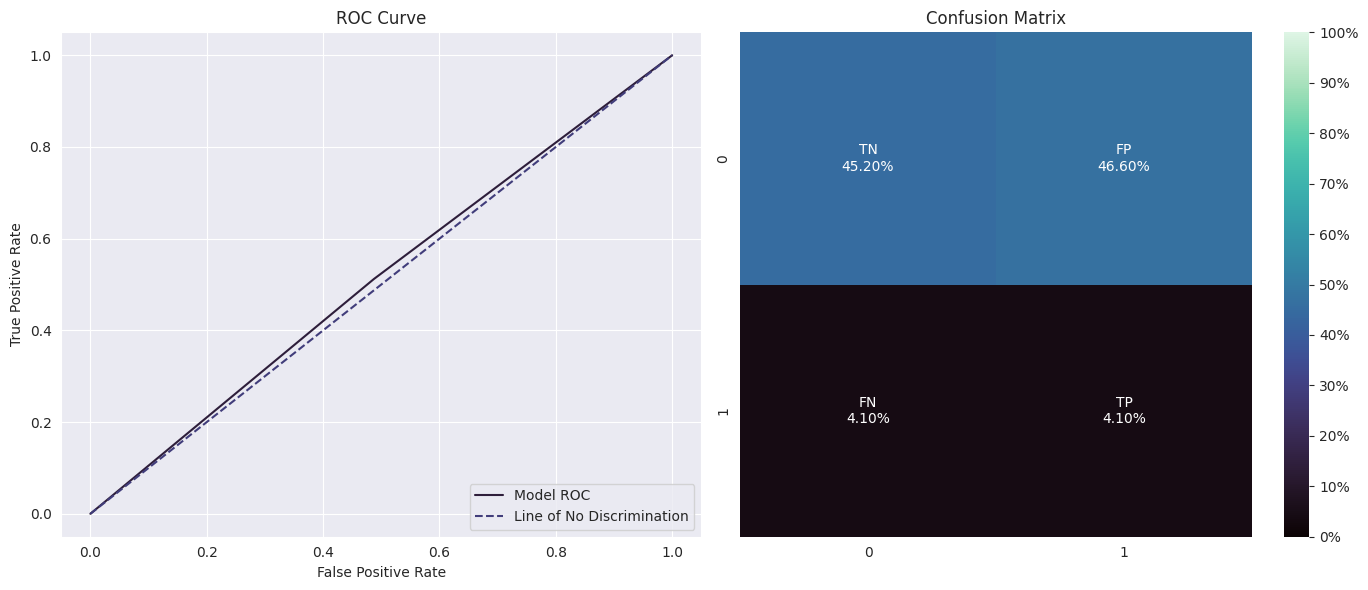

In [40]:
# Train a DummyClassifier with the imputed training data
# Since it's a baseline model, we don't perform hyperparameter tuning and set n_iter to 1
train_model(
    X_train=X_imputed_train,
    y_train=y_imputed_train,
    X_test=X_imputed_test,
    y_test=y_imputed_test,
    estimator=DummyClassifier(
        strategy="stratified"
    ),  # Using the 'stratified' strategy post-SMOTE for balanced prediction
    params={},  # No parameters to tune for DummyClassifier
    scorer=business_cost_scorer,  # Custom scoring function based on business cost
    n_iter=1,  # Single iteration since no tuning
    run_name="Dummy Classifier Business Cost CV",  # Name of the run for MLflow logging
    model_type="DummyClassifier",  # Model type for logging purposes
)

### Logistic Regression Hyperparameter Tuning using Business Cost

In this section, a Logistic Regression model is trained, focusing on optimizing its hyperparameters. The optimization process is centered around minimizing the business cost, making use of the custom `business_cost_scorer` for cross-validation.

Given the nature of hyperparameter space; to prevent potential compatibility and convergence warnings from cluttering the output, they are temporarily suppressed.

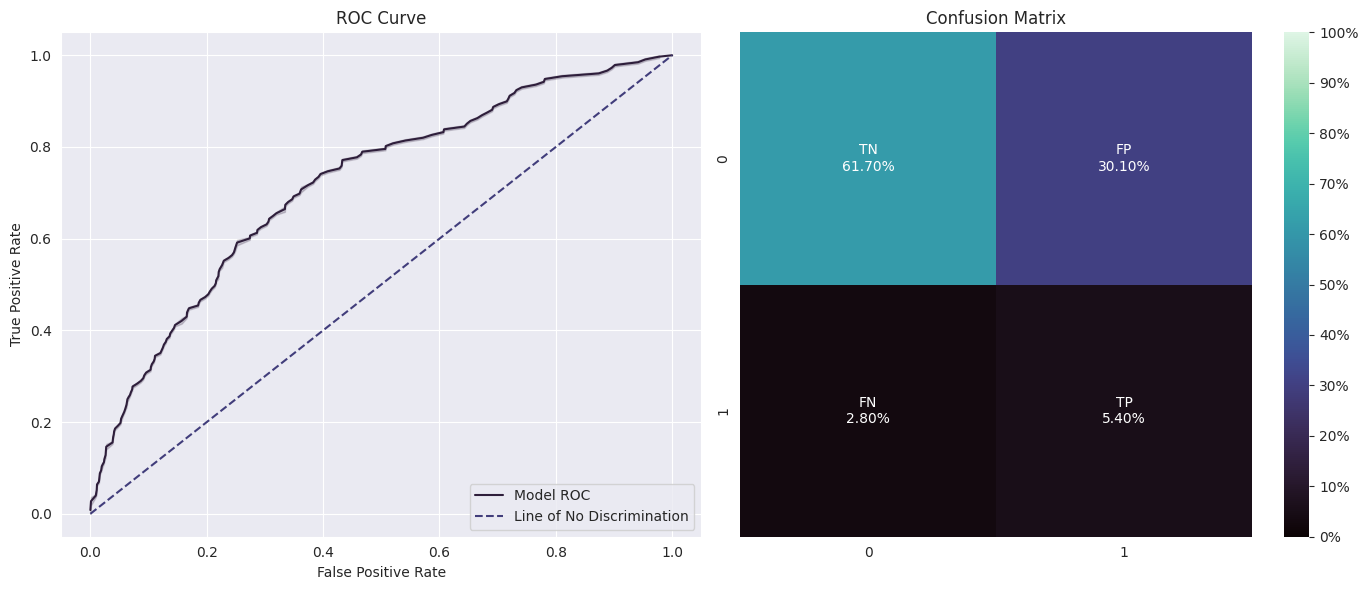

In [42]:
# Suppress potential warnings for clarity during execution
warnings.filterwarnings("ignore")

# Training the model using Logistic Regression and optimizing its hyperparameters
train_model(
    X_train=X_imputed_train,
    y_train=y_imputed_train,
    X_test=X_imputed_test,
    y_test=y_imputed_test,
    estimator=LogisticRegression(),  # Using Logistic Regression as the estimator
    # Defining the hyperparameter grid:
    # - C: inverse of regularization strength, where smaller values indicate stronger regularization
    # - penalty: type of regularization (L1, L2, or none)
    # - solver: optimization algorithm
    params={
        "classification__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "classification__penalty": ["l1", "l2", "none"],
        "classification__solver": ["newton-cg", "lbfgs", "saga"],
    },
    scorer=business_cost_scorer,  # Using the business cost as the scoring metric for optimization
    n_iter=50,  # Number of iterations for the RandomizedSearchCV
    run_name="Logistic Regression Business Cost CV",  # Name of this MLflow run for tracking
    model_type="LogisticRegression",  # Type of model being trained, for logging in MLflow
)

# Reset warnings behavior to default
warnings.filterwarnings("default")

### Logistic Regression Hyperparameter Tuning using AUC ROC

This is the same as the previous run, but uses AUC ROC rather then business cost for cross validation optimization.

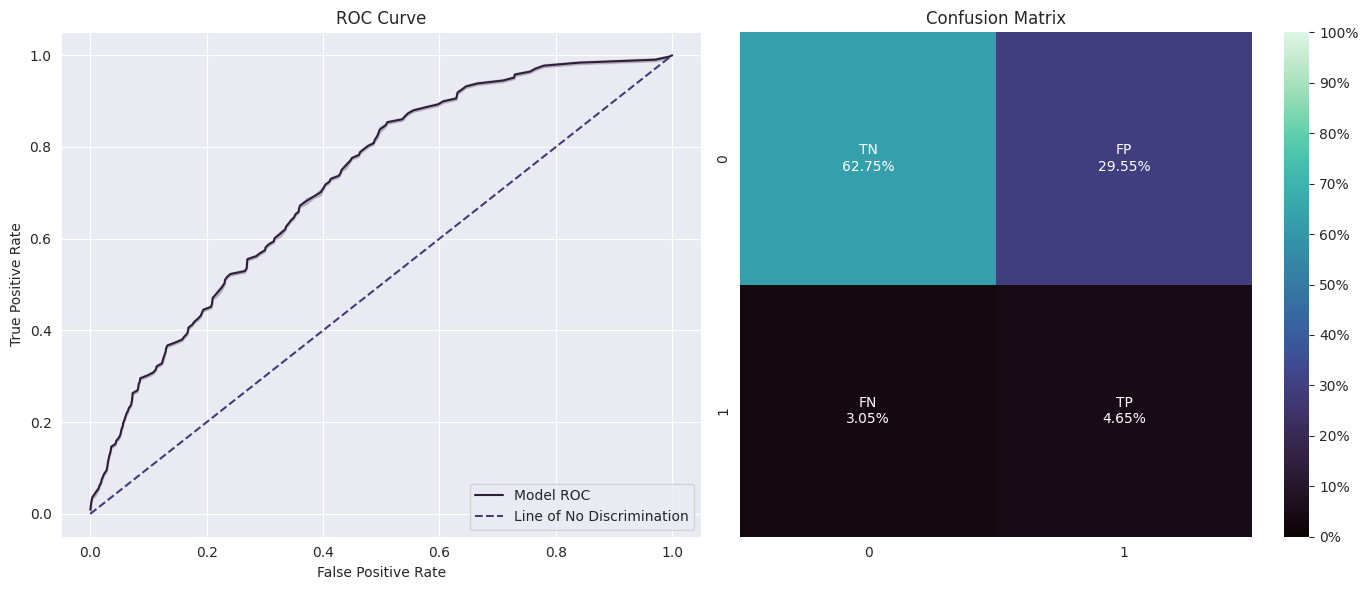

In [23]:
warnings.filterwarnings("ignore")

train_model(
    X_train=X_imputed_train,
    y_train=y_imputed_train,
    X_test=X_imputed_test,
    y_test=y_imputed_test,
    estimator=LogisticRegression(),
    params={
        "classification__C": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "classification__penalty": ["l1", "l2", "none"],
        "classification__solver": ["newton-cg", "lbfgs", "saga"],
    },
    scorer=roc_auc_scorer,  # Using the roc auc as the scoring metric for optimization
    n_iter=50,
    run_name="Logistic Regression AUC ROC CV",
    model_type="LogisticRegression",
)

warnings.filterwarnings("default")

### LightGBM Hyperparameter Tuning using Business Cost

In this section, we'll be training a LightGBM model. LightGBM is a gradient boosting framework that employs tree-based learning algorithms. We're focusing on optimizing its hyperparameters. As with the previous models, we are using the custom business_cost_scorer to guide our hyperparameter search and ultimately selecting the model that minimizes business costs during cross-validation.

shap_values() is deprecated; use __call__().


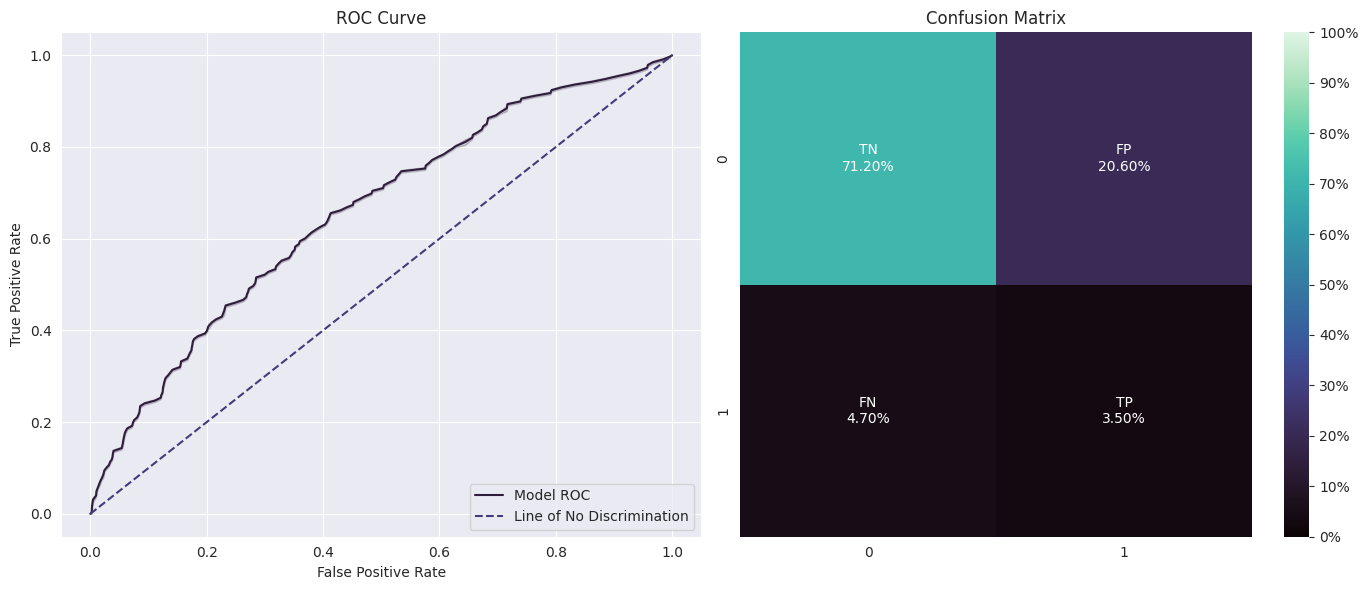

In [46]:
# Initiate hyperparameter tuning for the LGBMClassifier
train_model(
    X_train=X_imputed_train,
    y_train=y_imputed_train,
    X_test=X_imputed_test,
    y_test=y_imputed_test,
    estimator=lgb.LGBMClassifier(),
    params={
        # Controls the impact of each tree on prediction; common values to balance speed and accuracy
        "classification__learning_rate": [0.01, 0.05, 0.1],
        # Number of boosting iterations
        "classification__n_estimators": [10, 20, 50, 100, 200],
        # Algorithm type: two most common, gradient boosting and dropouts
        "classification__boosting_type": ["gbdt", "dart"],
        # Binary classification
        "classification__objective": ["binary"],
        # Maximum tree leaves for base learners; moderate values corresponding to potential depth
        "classification__num_leaves": [15, 30, 60],
        # Maximum tree depth for base learners; relatively short trees
        "classification__max_depth": [2, 3, 4],
        # Minimum number of data points per leaf; chosen for sufficient granularity to avoid overfitting
        "classification__min_child_samples": [20, 25, 30],
        # Fraction of features per tree; balances feature diversity and overfitting prevention.
        "classification__feature_fraction": [0.6, 0.8, 1.0],
        # Fraction of data for bagging; reduces overfitting while utilizing most of the dataset.
        "classification__bagging_fraction": [0.8, 0.9, 1.0],
        # Frequency of bagging; provides options from no bagging to every iteration.
        "classification__bagging_freq": [0, 1, 2],
        # L1 regularization helps in feature selection and prevents overfitting; none to modest regularization.
        "classification__reg_alpha": [0, 1, 2],
        # L2 regularization adds smoothness and stability to the model; none to modest regularization.
        "classification__reg_lambda": [0, 1, 10],
        # Not needed as bagging_fraction is used (prevents warnings)
        "classification__subsample": [None],
        # Not needed as feature_fraction is used (prevents warnings)
        "classification__colsample_bytree": [None],
        # Not needed as bagging_freq is used (prevents warnings)
        "classification__subsample_freq": [None],
    },
    scorer=business_cost_scorer,
    n_iter=50,
    run_name="LightGBM Business Cost CV",
    model_type="LGBMClassifier",
)

### LightGBM Hyperparameter Tuning using AUC ROC

This is the same as the previous run, but uses AUC ROC rather then business cost for cross validation optimization.

shap_values() is deprecated; use __call__().


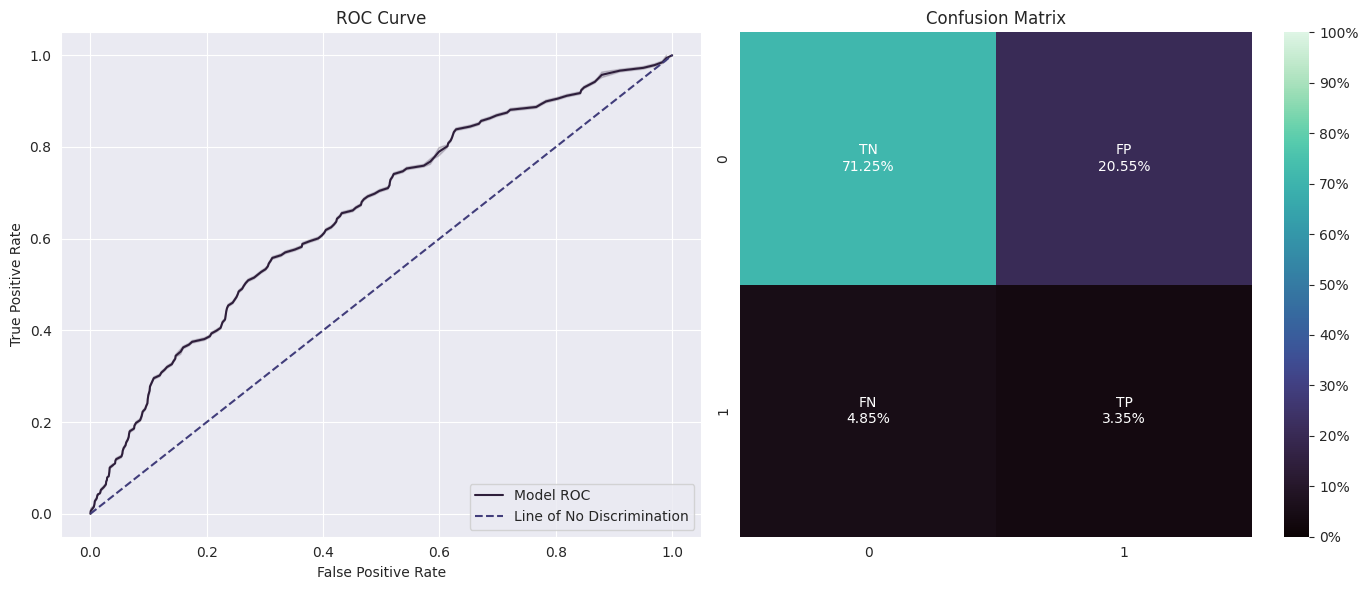

In [48]:
train_model(
    X_train=X_imputed_train,
    y_train=y_imputed_train,
    X_test=X_imputed_test,
    y_test=y_imputed_test,
    estimator=lgb.LGBMClassifier(),
    params={
        "classification__learning_rate": [0.01, 0.05, 0.1],
        "classification__n_estimators": [50, 100, 200],
        "classification__boosting_type": ["gbdt", "dart"],
        "classification__objective": ["binary"],
        "classification__num_leaves": [15, 30, 60],
        "classification__max_depth": [2, 3, 4, -1],
        "classification__min_child_samples": [20, 25, 30],
        "classification__feature_fraction": [0.6, 0.8, 1.0],
        "classification__bagging_fraction": [0.8, 0.9, 1.0],
        "classification__bagging_freq": [0, 1, 2],
        "classification__reg_alpha": [0, 1, 2],
        "classification__reg_lambda": [0, 1, 10],
        "classification__subsample": [None],
        "classification__colsample_bytree": [None],
        "classification__subsample_freq": [None],
    },
    scorer=roc_auc_scorer,
    n_iter=50,
    run_name="LightGBM AUC ROC CV",
    model_type="LGBMClassifier",
)

### Data Drift Analysis

In this section, the aim is to understand if there's any data drift between the training and test datasets for the independent features. Data drift can occur when the statistical properties of the input features, which the model uses for predictions, change over time. This can lead to model performance degradation if not addressed.

- The "Evidently" package is used to perform the analysis because of its ability to provide a comprehensive and visually intuitive report on feature drift, offering both statistical tests and visual plots to capture potential shifts in feature distributions.
- Drift detection configuration:
    - Numerical features statistical test: We use the Wasserstein Distance (also known as the Earth Mover's Distance) which measures the distance between two probability distributions. It essentially calculates the minimum cost required to transform one distribution into the other, providing a measure of dissimilarity. This method is sensitive to changes in location, scale, and shape of distributions, making it a robust choice for drift detection.
    - Categorical features: Note that all columns are treated as numerical due to preprocessing steps that have encoded or transformed original categorical variables.
- The report is generated and saved as `data_drift_report.html`.

In [68]:
# Prepare the datasets
drift_train_df = pd.read_feather("input/train_df.ftr")[
    top_sorted_correlations.index.tolist()
]
drift_test_df = pd.read_feather("input/test_df.ftr")[
    top_sorted_correlations.index.tolist()
]

# Create and run the Data Drift Report
data_drift_report = Report(metrics=[DataDriftPreset(num_stattest="wasserstein")])
data_drift_report.run(reference_data=drift_train_df, current_data=drift_test_df)

# Save report as HTML
data_drift_report.save_html("data_drift_report.html")